In [3]:
# Import essential libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut

# Load the merged dataset
merged_path = '/content/merged_processed_data.csv'  # Adjust path if necessary
data = pd.read_csv(merged_path)

# Separate numeric and non-numeric columns
numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()

# Replace inf/-inf with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values in numeric columns with their mean
data[numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())

# Select features and target
features = data.drop(columns=['Growth_Rate(g/2weeks)', 'bi_weekly_period', 'Average_Length(cm)', 'Average_Weight(g)'])  # Replace target if needed
target = data['Average_Weight(g)']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [4]:
def plot_validation_curve(model, X, y, title="Validation Curve"):
    """
    Plots training and validation errors against the training set size.

    Parameters:
    - model: The pipeline or model to evaluate.
    - X: Feature set.
    - y: Target variable.
    - title: Title of the plot.
    """
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_errors = -train_scores.mean(axis=1)
    valid_errors = -valid_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_errors, label="Training Error", marker='o')
    plt.plot(train_sizes, valid_errors, label="Validation Error", marker='s')
    plt.xlabel("Training Set Size")
    plt.ylabel("Mean Squared Error")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


In [5]:
# Pipeline for Linear Regression with scaling
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('model', LinearRegression())
])

# Pipelines for Random Forest and XGBoost
rf_pipeline = Pipeline([
    ('model', RandomForestRegressor(
        random_state=42,
        n_estimators=10,       # Fewer trees
        max_depth=5,           # Shallower trees
        max_features='sqrt'))
])

xgb_pipeline = Pipeline([
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_estimators=10,       # Fewer trees
        max_depth=2,           # Shallower trees
        learning_rate=0.5,     # Larger step size
        reg_alpha=0.2,         # L1 regularization
        reg_lambda=2           # L2 regularization
        ))
])



In [6]:
# Train Random Forest
rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)

# Train Linear Regression
lr_pipeline.fit(X_train, y_train)
lr_preds = lr_pipeline.predict(X_test)

# Train XGBoost
xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_test)

# Evaluate models
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)

lr_rmse = mean_squared_error(y_test, lr_preds, squared=False)
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_r2 = r2_score(y_test, lr_preds)

print(f"Linear Regression - RMSE: {lr_rmse}, MAE: {lr_mae}, R²: {lr_r2}")
print(f"Random Forest RMSE: {rf_rmse}, R²: {rf_r2}, MAE: {rf_mae}")
print(f"XGBoost RMSE: {xgb_rmse}, R²: {xgb_r2}, MAE: {xgb_mae}")


Linear Regression - RMSE: 4.261822135221176e-14, MAE: 3.220534949832654e-14, R²: 1.0
Random Forest RMSE: 0.4475652114674012, R²: 0.999946463861212, MAE: 0.2266638001071388
XGBoost RMSE: 0.7583795485348992, R²: 0.9998462880520426, MAE: 0.6966087831908814


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [7]:
# Cross-validation for Linear Regression
lr_cv_rmse = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
lr_cv_mae = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Cross-validation for Random Forest
rf_cv_rmse = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_cv_mae = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Cross-validation for XGBoost
xgb_cv_rmse = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
xgb_cv_mae = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Print cross-validation results
print(f"Linear Regression CV - RMSE: {np.sqrt(-lr_cv_rmse.mean())}, MAE: {-lr_cv_mae.mean()}")
print(f"Random Forest CV - RMSE: {np.sqrt(-rf_cv_rmse.mean())}, MAE: {-rf_cv_mae.mean()}")
print(f"XGBoost CV - RMSE: {np.sqrt(-xgb_cv_rmse.mean())}, MAE: {-xgb_cv_mae.mean()}")

Linear Regression CV - RMSE: 4.441773411266578e-14, MAE: 3.425423687387689e-14
Random Forest CV - RMSE: 0.9503683256310004, MAE: 0.3783253686915082
XGBoost CV - RMSE: 0.7021461220077709, MAE: 0.5285570610092599


                                    Feature  Importance
0                           Temperature (C)    0.356271
4                            Ammonia (g/ml)    0.155886
23                      Nitrate (g/ml)_Diff    0.153571
5                            Nitrate (g/ml)    0.081402
16               Nitrate (g/ml)_RollingMean    0.072589
2                   Dissolved Oxygen (g/ml)    0.059023
21                                  pH_Diff    0.032403
10      Dissolved Oxygen (g/ml)_RollingMean    0.024339
12                           pH_RollingMean    0.019239
7           Temperature (C)_RollingVariance    0.010432
17           Nitrate (g/ml)_RollingVariance    0.008871
3                                        pH    0.007617
9           Turbidity (NTU)_RollingVariance    0.007453
18                     Temperature (C)_Diff    0.004194
11  Dissolved Oxygen (g/ml)_RollingVariance    0.003762
8               Turbidity (NTU)_RollingMean    0.002037
13                       pH_RollingVariance    0

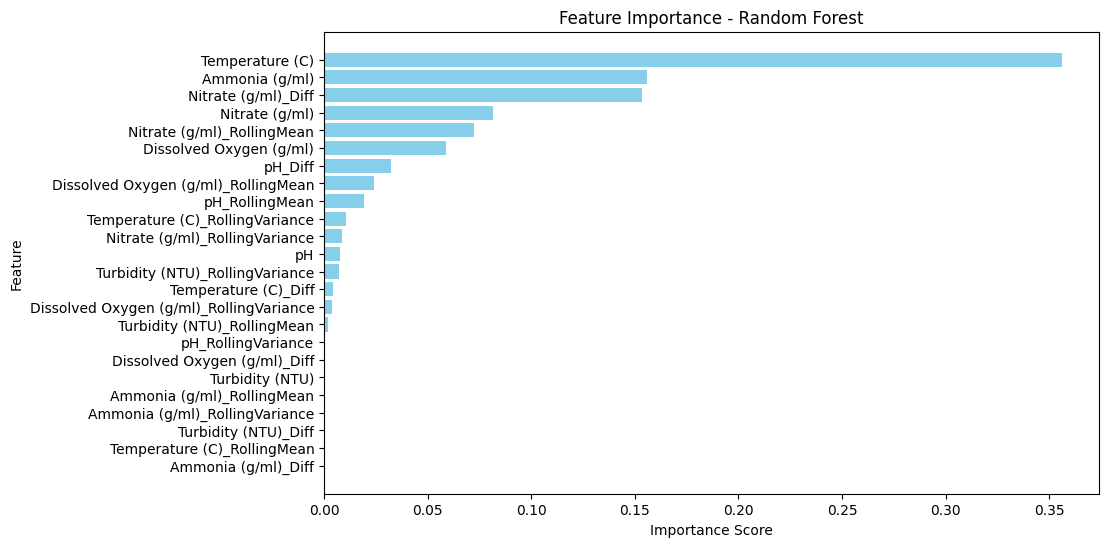

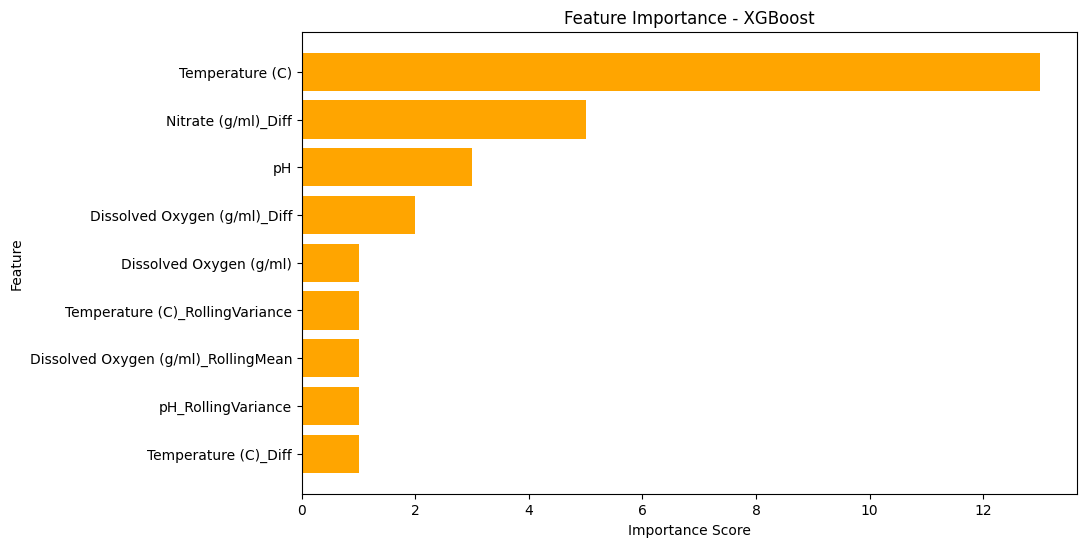

['Temperature (C)',
 'Turbidity (NTU)',
 'Dissolved Oxygen (g/ml)',
 'pH',
 'Ammonia (g/ml)',
 'Nitrate (g/ml)',
 'Temperature (C)_RollingMean',
 'Temperature (C)_RollingVariance',
 'Turbidity (NTU)_RollingMean',
 'Turbidity (NTU)_RollingVariance',
 'Dissolved Oxygen (g/ml)_RollingMean',
 'Dissolved Oxygen (g/ml)_RollingVariance',
 'pH_RollingMean',
 'pH_RollingVariance',
 'Ammonia (g/ml)_RollingMean',
 'Ammonia (g/ml)_RollingVariance',
 'Nitrate (g/ml)_RollingMean',
 'Nitrate (g/ml)_RollingVariance',
 'Temperature (C)_Diff',
 'Turbidity (NTU)_Diff',
 'Dissolved Oxygen (g/ml)_Diff',
 'pH_Diff',
 'Ammonia (g/ml)_Diff',
 'Nitrate (g/ml)_Diff']

In [8]:
# For Random Forest
feature_importances = rf_pipeline.named_steps['model'].feature_importances_
importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})
print(importance_df.sort_values(by='Importance', ascending=False))
# Sort feature importance by descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance - Random Forest")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


# Extract feature importance from XGBoost model
xgb_importances = xgb_pipeline.named_steps['model'].get_booster().get_score(importance_type='weight')
xgb_importance_df = pd.DataFrame({
    'Feature': xgb_importances.keys(),
    'Importance': xgb_importances.values()
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'], color='orange')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance - XGBoost")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()
xgb_pipeline.named_steps['model'].get_booster().feature_names


In [9]:
# employing LOO for further model validation
loo = LeaveOneOut()

rf_rmse_list = []
xgb_rmse_list = []

for train_index, test_index in loo.split(features):
    X_train_loo, X_test_loo = features.iloc[train_index], features.iloc[test_index]
    y_train_loo, y_test_loo = target.iloc[train_index], target.iloc[test_index]

    # Train Random Forest
    rf_pipeline.fit(X_train_loo, y_train_loo)
    rf_preds = rf_pipeline.predict(X_test_loo)
    rf_rmse_list.append(mean_squared_error(y_test_loo, rf_preds, squared=False))

    # Train XGBoost
    xgb_pipeline.fit(X_train_loo, y_train_loo)
    xgb_preds = xgb_pipeline.predict(X_test_loo)
    xgb_rmse_list.append(mean_squared_error(y_test_loo, xgb_preds, squared=False))

# Summary statistics
print(f"Random Forest LOO-CV RMSE: Mean={np.mean(rf_rmse_list)}, Std Dev={np.std(rf_rmse_list)}")
print(f"XGBoost LOO-CV RMSE: Mean={np.mean(xgb_rmse_list)}, Std Dev={np.std(xgb_rmse_list)}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

Random Forest LOO-CV RMSE: Mean=0.24119128753398897, Std Dev=0.3495562539882743
XGBoost LOO-CV RMSE: Mean=0.3585323282312505, Std Dev=0.29267988534980327


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


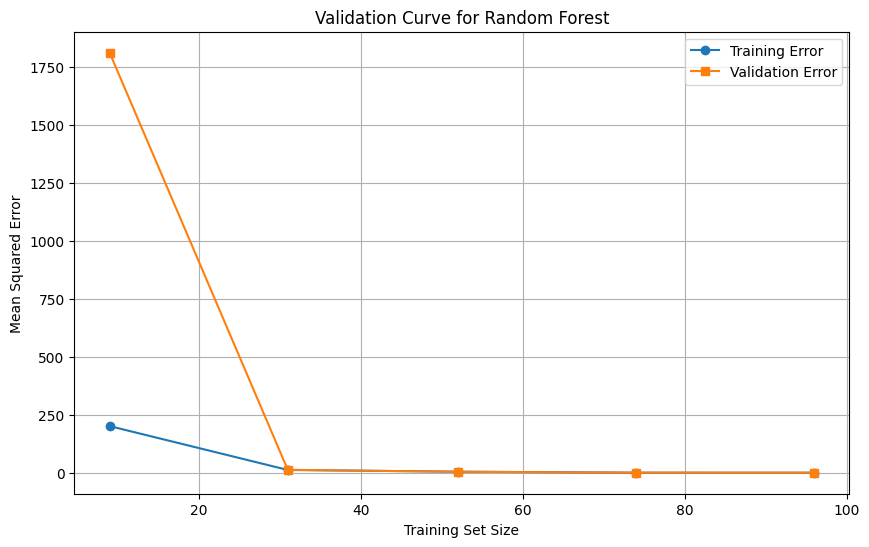

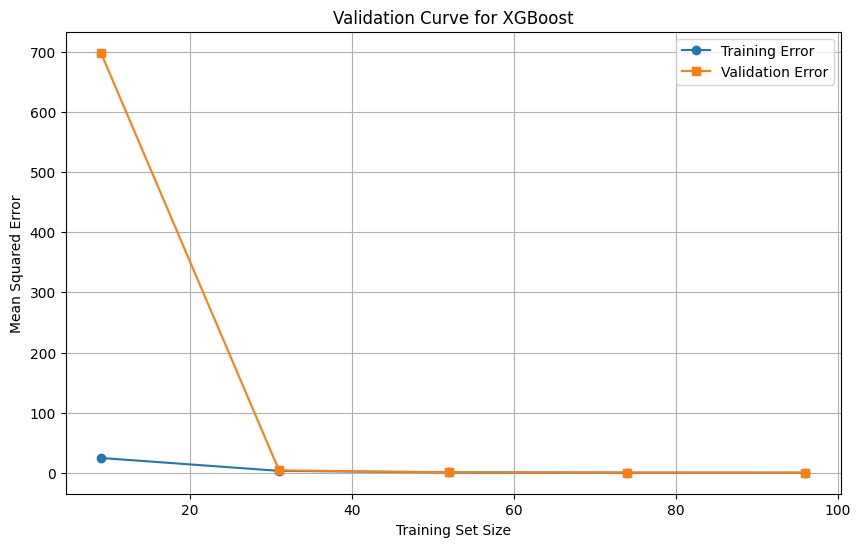

In [10]:
# Random Forest Validation Curve
plot_validation_curve(rf_pipeline, features, target, title="Validation Curve for Random Forest")

# XGBoost Validation Curve
plot_validation_curve(xgb_pipeline, features, target, title="Validation Curve for XGBoost")
